In [1]:
import numpy as np
import matplotlib.pyplot as plt

###################################################
#  Katie Chamberlain  -  May 2019                 #
#  Use abundance matching code to determine halo  #
#  mass constraints for the LMC with              # 
#  M* = 2.5x10^9Msun   (Besla 2015b)              #
#  ...                                            #
#  AM Follows Moster, Naab, and White (2013)      #
#  https://arxiv.org/pdf/1205.5807.pdf            #
###################################################
f = np.random.normal


In [2]:
class AM:
    def __init__(self, M, z, kind = "median"):
        
        #initializing the AM parameters:
        self.M = M
        self.z = z
        self.kind = kind
        
        
    def logM1(self):
        """eq. 11"""
        M10      = 11.59
        M10range = 0.236
        M11      = 1.195
        M11range = 0.353

        if self.kind == "median":                 # picking out only the median value
            return M10 + M11*(self.z/(1+self.z))
        else:                                # picking gaussian distributed variables
            M10Gauss, M11Gauss = f(M10, M10range,1), f(M11, M11range, 1)
            return M10Gauss + M11Gauss*(self.z/(1+self.z))
    
    def N(self):
        """eq. 12"""
        N10      = 0.0351
        N10range = 0.0058
        N11      = -0.0247
        N11range = 0.0069

        if self.kind == "median":                 # picking out only the median value
            return N10 + N11*(self.z/(1+self.z))
        else:                                # picking gaussian distributed variables
            N10Gauss, N11Gauss = f(N10, N10range,1),f(N11, N11range, 1)
            return N10Gauss + N11Gauss*(self.z/(1+self.z))

    def beta(self):
        """eq. 13"""
        beta10      = 1.376
        beta10range = 0.153
        beta11      = -0.826
        beta11range = 0.225

        if self.kind == "median":                 # picking out only the median value
            return beta10 + beta11*(self.z/(1+self.z))
        else:                                # picking gaussian distributed variables
            beta10Gauss, beta11Gauss = f(beta10, beta10range,1),f(beta11, beta11range, 1)
            return beta10Gauss + beta11Gauss*(self.z/(1+self.z))   

    def gamma(self):
        """eq. 14"""
        gamma10      = 0.608
        gamma10range = 0.059
        gamma11      = 0.329
        gamma11range = 0.173

        if self.kind == "median":                 # picking out only the median value
            return gamma10 + gamma11*(self.z/(1+self.z))
        else:                                # picking gaussian distributed variables
            gamma10Gauss, gamma11Gauss = f(gamma10, gamma10range,1),f( gamma11, gamma11range, 1)
            return gamma10Gauss + gamma11Gauss*(self.z/(1+self.z))

    def SHMratio(self):
        """
        Inputs: masses M in solar masses (NOT in logspce)
        Returns: Stellar mass to halo mass ratio
        """
        M1 = 10**self.logM1()
        A = (self.M/M1)**(-self.beta())
        B = (self.M/M1)**(self.gamma())
        SHMratio = 2*self.N()*(A+B)**-1
        return SHMratio

    def stellarMass(self):
        """ returns the stellar mass in Msun """
        return self.M*self.SHMratio()

    def bounds(self, x):
        """ 
        finding x-sigma bounds on the stellar mass
        via error propagation 
        credit: Mark Vogelsberger and Gurtina Besla
        Inputs: mass in solar mass
        Outputs: upper and lower stellar mass at x-sigma from mean
        """
        Ms = self.M
        z = self.z
        
        N1 = self.N()
        M1 = self.logM1()
        Beta1 = self.beta()
        Gamma1 = self.gamma()
        a = 1/(1+self.z)

        M = np.log10(Ms)

        M10range, M11range = 0.236, 0.353
        N10range, N11range = 0.0058, 0.0069
        B10range, B11range = 0.153, 0.225
        G10range, G11range = 0.059, 0.173

        Mstar = M + np.log10(2*N1) - np.log10( (10**(M-M1))**(-Beta1) + (10**(M-M1))**(Gamma1) ) 
        dmdN10 = np.log10(np.e)/N1
        dmdN11 = dmdN10*(1.0-a)

        eta = np.exp(np.log(10.0)*(M-M1))
        alpha = eta**(-Beta1) + eta**(Gamma1)
        dmdM10 = (Gamma1*eta**(Gamma1) - Beta1*eta**(-Beta1))/alpha
        dmdM11 = (Gamma1*eta**(Gamma1) - Beta1*eta**(-Beta1))/alpha*(1.0-a)
        dmdB10 = np.log10(np.e)/alpha*np.log(eta)*eta**(-Beta1)
        dmdB11 = np.log10(np.e)/alpha*np.log(eta)*eta**(-Beta1)*(1.0-a)
        dmdG10 = -np.log10(np.e)/alpha*np.log(eta)*eta**(Gamma1)
        dmdG11 = -np.log10(np.e)/alpha*np.log(eta)*eta**(Gamma1)*(1.0-a)

        sigma = np.sqrt(dmdM10**2.0*M10range**2.0 + dmdM11**2.0*M11range**2.0 + dmdN10**2.0*N10range**2.0 + dmdN11**2.0*N11range**2.0 + dmdB10**2.0*B10range**2.0 + dmdB11**2.0*B11range**2.0 + dmdG10**2.0*G10range**2.0 + dmdG11**2.0*G11range**2.0)

        Mstaru = Mstar + (sigma*x)
        Mstarl = Mstar - (sigma*x)

        return 10**Mstaru, 10**Mstarl
 


In [3]:
inst = AM(1e10, 0)
star = inst.stellarMass()
star

4551902.73037931

In [36]:
inst = AM(1e10, 1,"gauss")
test = [1e10, 1e10, 1e10]
trials     = 10
Ms          = np.logspace(10,15,1)
MsGauss    = np.concatenate([Ms]*trials)
mstarGauss = np.concatenate([AM(Ms,0,"gauss").stellarMass() for i in range(trials)])
print(mstarGauss)
print([AM(i, 1,"gauss").stellarMass() for i in test])
upper1, lower1 = inst.bounds(1)                           # one sigma bounds on mstar
upper2, lower2 = inst.bounds(2)

[ 1694119.09230962  2397362.94633556  7318830.65165565  3925586.79344775
  7495853.44906802  7303677.1092945  13700392.68525888 13599516.34799157
 17247684.27288854  5088737.16435392]
[array([10772726.59209851]), array([4702172.25970097]), array([364648.99174365])]
[6.7311436]
[6.79307279]


---

In [13]:
def plottingRoutine(z=0, kind = "random"):
    
    if kind == "random":
        Ms          = np.logspace(10,15,1000)                       # logarithmically spaced halo masses
        mstarMedian = stellarMass(Ms, z)                            # median mstar masses
        
        numPoints   = 100000                                        # number of random draws to make
        MsGauss     = 10**(5*np.random.rand(numPoints)+10)          # random halo mass vals
        mstarGauss  = [stellarMass(i, z, "gauss") for i in MsGauss]  # draws from gaussian dists

        numBins      = 150
        binsx, binsy = np.logspace(10,15,numBins),np.logspace(8,12, numBins) # bin definitions
    
    else:
        numPoints   = 10000
        Ms          = np.logspace(10,15,numPoints)                  # logarithmically spaced halo masses
        mstarMedian = stellarMass(Ms, z)                            # median mstar masses

        trials     = 10000
        MsGauss    = np.concatenate([Ms]*trials)
        mstarGauss = np.concatenate([stellarMass(Ms,0,"gauss") for i in range(trials)])

        numBins      = 150
        binsx, binsy = np.logspace(10,15,numBins),np.logspace(8,12,numBins)
        
    upper1, lower1 = bounds(Ms, z, 1)                           # one sigma bounds on mstar
    upper2, lower2 = bounds(Ms, z, 2)                           # two sigma bounds on mstar  
    
    fig,ax = plt.subplots(figsize=(10,8))
    plt.hist2d(MsGauss,mstarGauss,bins=[binsx, binsy],cmap = "RdPu")
    plt.plot(Ms,mstarMedian,label = 'Median',color='black')
    plt.plot(Ms,upper1,'--',label = '1$\sigma$',lw = 1,color='black')
    plt.plot(Ms,lower1,'--',color='black',lw = 1)
    plt.plot(Ms,upper2,'--',label = '2$\sigma$',lw = .5,ms = 2,color='black')
    plt.plot(Ms,lower2,'--',color='black',lw=0.5)
    plt.title('z = '+str(z))
    plt.xlabel('M$_h$')
    plt.ylabel('m$_\star$')
    plt.legend()
    plt.yscale('log')
    plt.xscale('log')
#    plt.savefig('abundanceMatchingPlots/z'+str(z)+'.png', bbox_inches='tight',dpi=1200)
    plt.show()

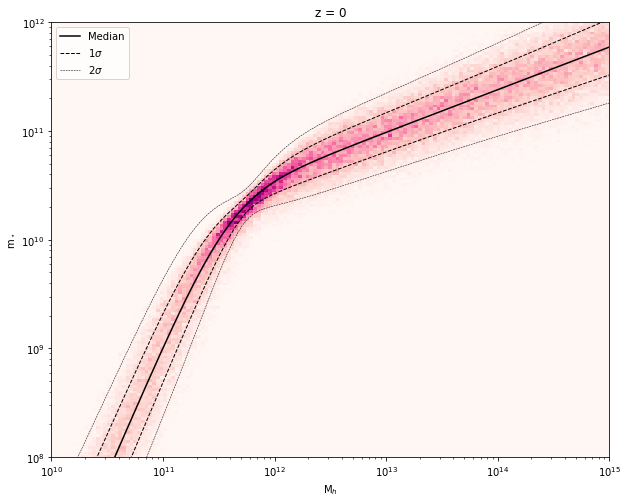

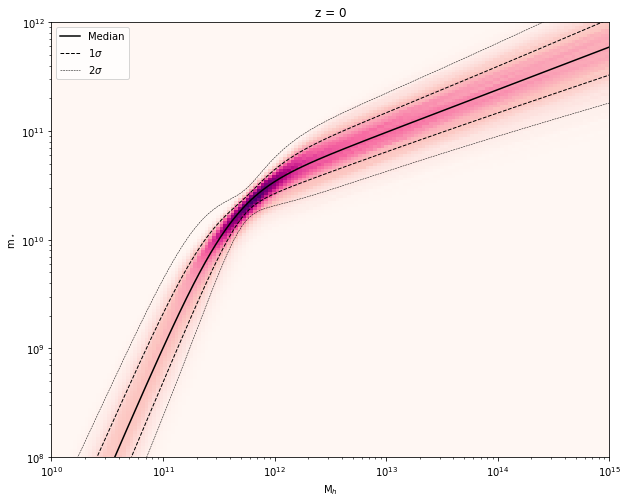

In [20]:
plottingRoutine()
plottingRoutine(0,"gauss")

---

In [6]:
numPoints = 10000
Ms = np.logspace(10,15,numPoints)
MsRand = 10**(5*np.random.rand(numPoints)+10)

mstarz0   = MsRand*SHMratio(MsRand,0,"gauss")
mstarMedian= Ms*SHMratio(Ms,0)

#----------------------------------------------#

trials = 10000
Mss = np.concatenate([MsRand]*trials)
Ratios = np.concatenate([MsRand*SHMratio(MsRand,0,"gauss") for i in range(trials)])

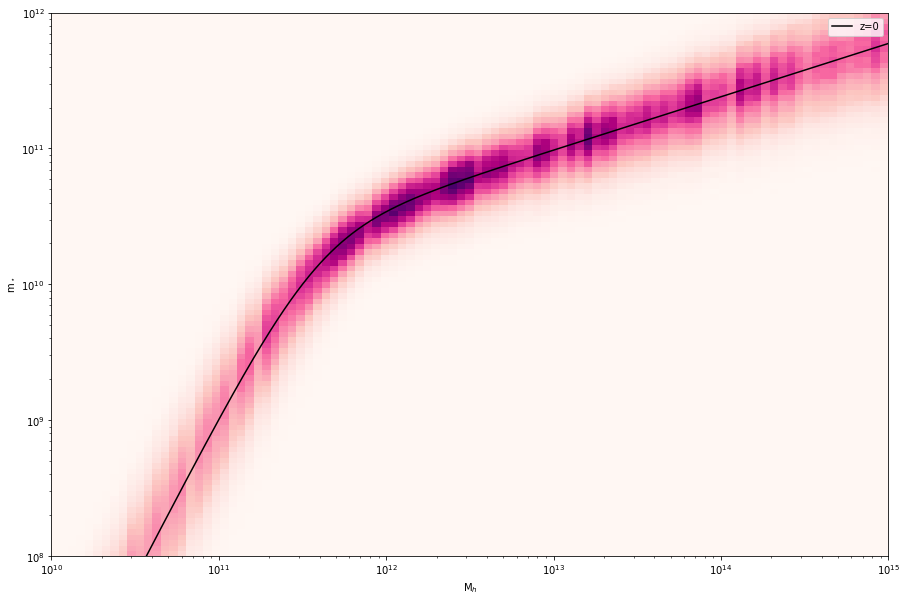

In [7]:
binsx, binsy = np.logspace(10,15,100),np.logspace(8,12,100)

fig,ax = plt.subplots(figsize=(15,10))
plt.hist2d(Mss,Ratios,bins=[binsx, binsy],label = 'z=0',cmap = "RdPu")
plt.plot(Ms,mstarMedian,label = 'z=0',color='black')
plt.xlabel('M$_h$')
plt.ylabel('m$_\star$')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.show()

---

In [21]:
numPoints = 10000

Ms = np.logspace(10,15,numPoints)
MsRand = np.logspace(10,15,numPoints)

mstarMedian= Ms*SHMratio(Ms,0)
mstarz0   = MsRand*SHMratio(MsRand,0,"gauss")

#----------------------------------------------#

trials = 10000
Mss = np.concatenate([MsRand]*trials)
Ratios = np.concatenate([MsRand*SHMratio(MsRand,0,"gauss") for i in range(trials)])

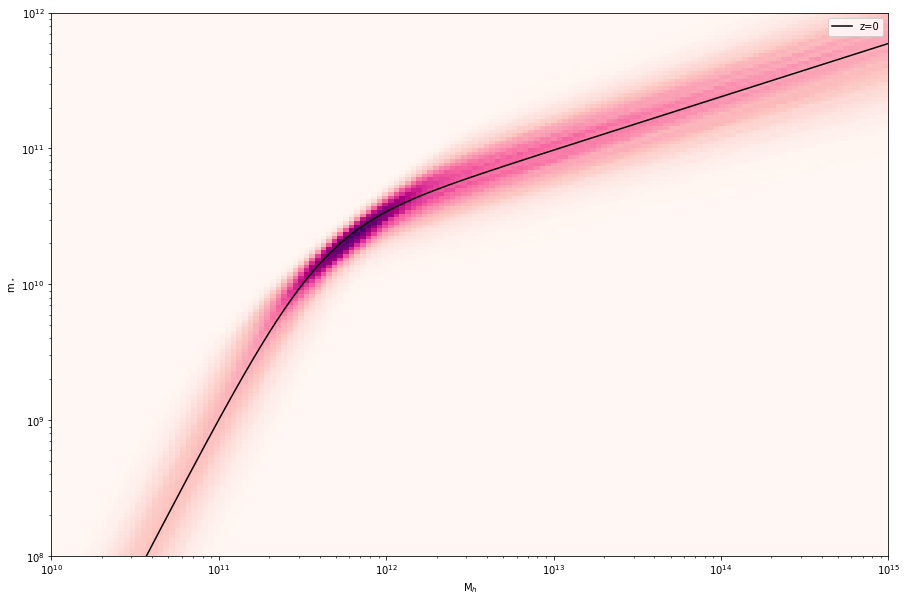

In [22]:
binsx, binsy = np.logspace(10,15,150),np.logspace(8,12,150)

fig,ax = plt.subplots(figsize=(15,10))
plt.hist2d(Mss,Ratios,bins=[binsx, binsy],label = 'z=0',cmap = "RdPu")
plt.plot(Ms,mstarMedian,label = 'z=0',color='black')
plt.xlabel('M$_h$')
plt.ylabel('m$_\star$')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.show()

---

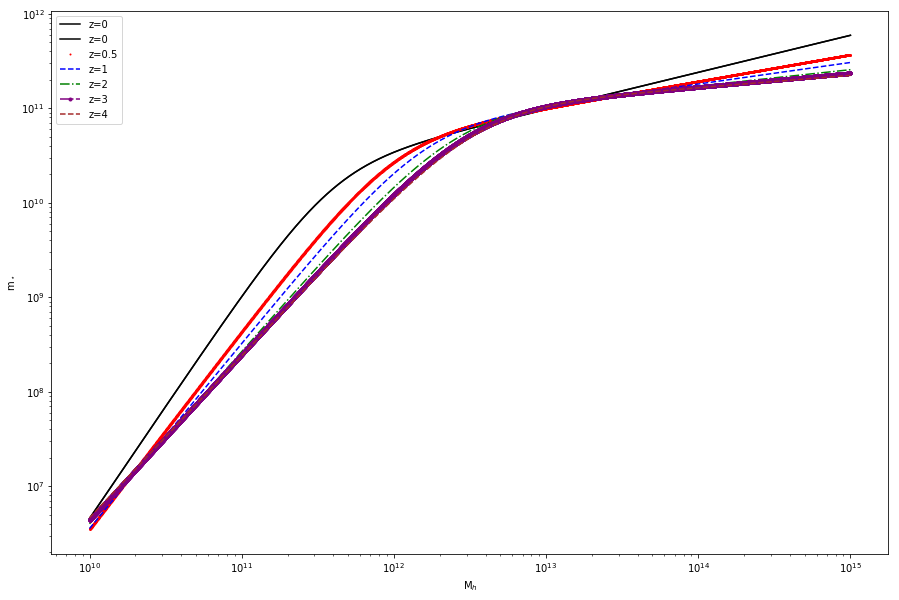

In [74]:
Ms        = np.logspace(10,15,numPoints)
mstarz0   = Ms*SHMratio(Ms,0)
mstarz02  = Ms*SHMratio(Ms,0)
mstarz0p5 = Ms*SHMratio(Ms,0.5)
mstarz1   = Ms*SHMratio(Ms,1)
mstarz2   = Ms*SHMratio(Ms,2)
mstarz3   = Ms*SHMratio(Ms,3)
mstarz4   = Ms*SHMratio(Ms,4)

fig,ax = plt.subplots(figsize=(15,10))
plt.plot(Ms,mstarz0,label = 'z=0',color='black')
plt.plot(Ms,mstarz02,label = 'z=0',color='black')
plt.plot(Ms,mstarz0p5,'.',ms=2,label = 'z=0.5',color='red')
plt.plot(Ms,mstarz1,'--',label = 'z=1',color='blue')
plt.plot(Ms,mstarz2,'-.',label = 'z=2',color='green')
plt.plot(Ms,mstarz3,'-..',label = 'z=3',color='purple')
plt.plot(Ms,mstarz4,'--',label = 'z=4',color='brown')
plt.xlabel('M$_h$')
plt.ylabel('m$_\star$')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.show()